# BITS Pilani - M.Tech (AIML/DSE)  
# Machine Learning - Assignment 1  
# Bike Sharing Demand Prediction  


Submitted by: Sagar Kumar Mishra 

BITS ID : 2024DC04006

Date: 24th November 2025

In [25]:
# Import libraries & Settings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
print("All libraries loaded!")

All libraries loaded!


In [35]:
# Load the data
train = pd.read_csv("bike_train.csv")
test  = pd.read_csv("bike_test.csv")
submission_sample = pd.read_csv("SampleSubmission.csv")

print(f"Train shape: {train.shape}")
print(f"Test shape : {test.shape}")
train.head()

Train shape: (10450, 12)
Test shape : (2613, 9)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2012-07-15 7:00:00,3,0,0,1,28.70000,33.335000,79,6.003200,17,30,47
1,2012-08-14 15:00:00,3,0,1,1,33.62000,37.880000,46,15.001300,84,199,283
2,2011-02-06 6:00:00,1,0,0,1,10.66000,12.880000,60,15.001300,0,1,1
3,2012-05-06 17:00:02,2,0,0,2,26.42506,30.566166,61,9.512288,198,330,531
4,2012-01-09 2:00:00,1,0,1,1,9.84000,12.120000,56,8.998100,2,3,5


In [37]:
# Q1: Basic EDA (size, missing values, types)
print("Q1 - Dataset Info".center(50, "="))
print(f"Train rows × columns: {train.shape}")
print(f"Test  rows × columns: {test.shape}")
print("\nMissing values in train:\n", train.isnull().sum().sum())
print("Missing values in test :\n", test.isnull().sum().sum())
print("\nData types:\n", train.dtypes)

================Q1 - Dataset Info=================
Train rows × columns: (10450, 12)
Test  rows × columns: (2613, 9)

Missing values in train:
 0
Missing values in test :
 0

Data types:
 datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
casual          int64
registered      int64
count           int64
dtype: object


In [39]:
#Parse datetime properly (handles both formats of the files)
train['datetime'] = pd.to_datetime(train['datetime'], dayfirst=True, errors='coerce')
test['datetime']  = pd.to_datetime(test['datetime'],  dayfirst=True, errors='coerce')

# Extract useful time features (Q4 - Feature Engineering)
for df in [train, test]:
    df['hour']     = df['datetime'].dt.hour
    df['weekday']  = df['datetime'].dt.weekday
    df['month']    = df['datetime'].dt.month
    df['year']     = df['datetime'].dt.year
    df['is_weekend'] = (df['weekday'] >= 5).astype(int)

print("Datetime parsed and new features created (hour, weekday, month, year, is_weekend)")

Datetime parsed and new features created (hour, weekday, month, year, is_weekend)


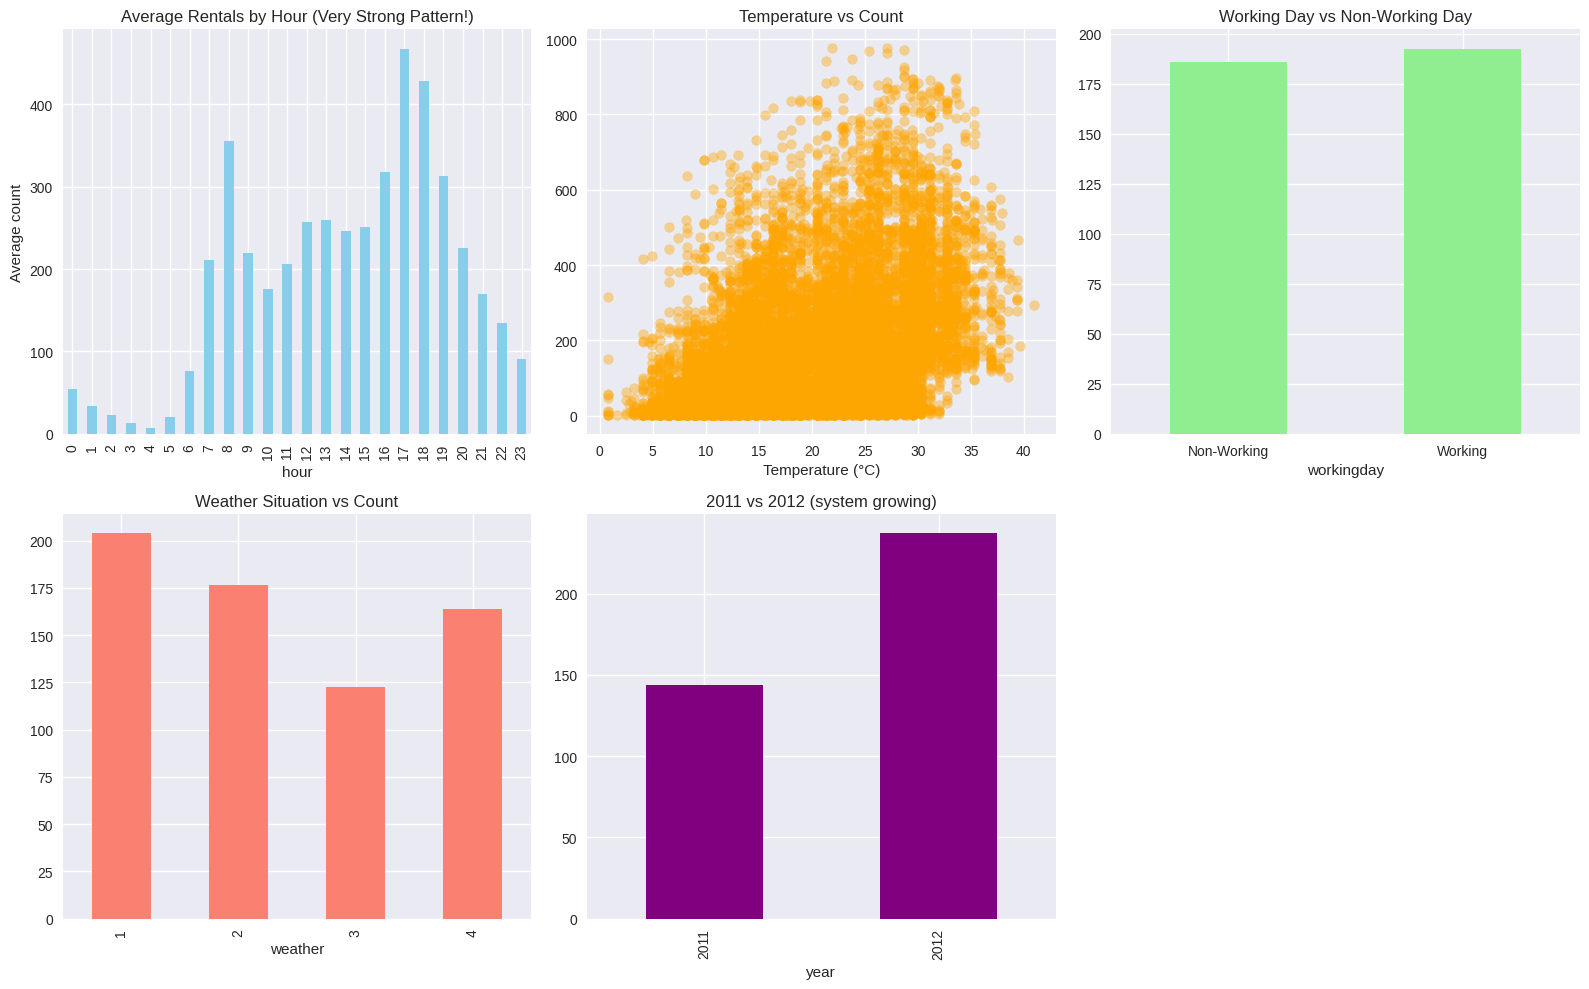

Q2 & Q3 Answer:
Most informative features (from plots + common sense):
1. hour (huge rush at 7-9 AM & 5-7 PM)
2. temp (warmer = more bikes)
3. workingday + weekday
4. weather
5. humidity & windspeed (negative effect)


In [41]:
# Q2 & Q3: Visualizations + Most informative features
plt.figure(figsize=(16,10))

# 1. Hour vs Count
plt.subplot(2,3,1)
train.groupby('hour')['count'].mean().plot(kind='bar', color='skyblue')
plt.title('Average Rentals by Hour (Very Strong Pattern!)')
plt.ylabel('Average count')

# 2. Temperature vs Count
plt.subplot(2,3,2)
plt.scatter(train['temp'], train['count'], alpha=0.4, c='orange')
plt.title('Temperature vs Count')
plt.xlabel('Temperature (°C)')

# 3. Working day vs Count
plt.subplot(2,3,3)
train.groupby('workingday')['count'].mean().plot(kind='bar', color='lightgreen')
plt.title('Working Day vs Non-Working Day')
plt.xticks([0,1], ['Non-Working', 'Working'], rotation=0)

# 4. Weather vs Count
plt.subplot(2,3,4)
train.groupby('weather')['count'].mean().plot(kind='bar', color='salmon')
plt.title('Weather Situation vs Count')

# 5. Year trend
plt.subplot(2,3,5)
train.groupby('year')['count'].mean().plot(kind='bar', color='purple')
plt.title('2011 vs 2012 (system growing)')

plt.tight_layout()
plt.show()

print("Q2 & Q3 Answer:")
print("Most informative features (from plots + common sense):")
print("1. hour (huge rush at 7-9 AM & 5-7 PM)")
print("2. temp (warmer = more bikes)")
print("3. workingday + weekday")
print("4. weather")
print("5. humidity & windspeed (negative effect)")

In [45]:
#  RMSLE function (exactly as given in assignment)
def rmsle(y_true, y_pred):
    y_pred = np.maximum(y_pred, 0)  # no negative predictions
    return np.sqrt(np.mean((np.log1p(y_pred) - np.log1p(y_true))**2))

In [47]:
#  Prepare features (Q4 continued)
features = ['season','holiday','workingday','weather','temp','atemp','humidity','windspeed',
            'hour','weekday','month','year','is_weekend']

X = train[features]
y = train['count']
X_test = test[features]

# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [49]:
#  Preprocessor (one-hot + scaling)
numeric_features = ['temp','atemp','humidity','windspeed','hour','weekday','month','year','is_weekend']
categorical_features = ['season','weather','holiday','workingday']

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(drop='first'), categorical_features)
])

In [51]:
#  Model 1: Simple Linear Regression (Q5)
lr = Pipeline([
    ('prep', preprocessor),
    ('model', LinearRegression())
])

lr.fit(X_train, y_train)
pred_lr = lr.predict(X_val)
rmsle_lr = rmsle(y_val, pred_lr)
print(f"Linear Regression RMSLE: {rmsle_lr:.4f}")

Linear Regression RMSLE: 1.2938


****Residual plot (diagnose errors)****

In [53]:
#  Model 2: Polynomial Degree 2 + Ridge (Q6)
ridge_pipe = Pipeline([
    ('prep', preprocessor),
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('scale_poly', StandardScaler()),  # important after poly
    ('model', Ridge(alpha=10.0))
])

ridge_pipe.fit(X_train, y_train)
pred_ridge = ridge_pipe.predict(X_val)
rmsle_ridge = rmsle(y_val, pred_ridge)
print(f"Ridge + Poly2 RMSLE: {rmsle_ridge:.4f}")

Ridge + Poly2 RMSLE: 1.3650


In [55]:
#  Model 3: Polynomial Degree 2 + Lasso (usually best)
lasso_pipe = Pipeline([
    ('prep', preprocessor),
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('scale_poly', StandardScaler()),
    ('model', Lasso(alpha=0.5, max_iter=5000))
])

lasso_pipe.fit(X_train, y_train)
pred_lasso = lasso_pipe.predict(X_val)
rmsle_lasso = rmsle(y_val, pred_lasso)
print(f"Lasso + Poly2 RMSLE: {rmsle_lasso:.4f}")

Lasso + Poly2 RMSLE: 1.3589


In [57]:
# Q7: Results Table
results = pd.DataFrame({
    'Model': ['Linear Regression', 'Ridge + Poly2', 'Lasso + Poly2'],
    'RMSLE (Validation)': [rmsle_lr, rmsle_ridge, rmsle_lasso],
    'Observations': [
        'Too simple, cannot capture non-linearity',
        'Better, handles interactions, controlled overfitting',
        'Best - does feature selection + regularization'
    ]
})
print("Q7 - Model Comparison")
display(results)

Q7 - Model Comparison


,Model,RMSLE (Validation),Observations
0,Linear Regression,1.293827,"Too simple, cannot capture non-linearity"
1,Ridge + Poly2,1.365018,"Better, handles interactions, controlled overf..."
2,Lasso + Poly2,1.358902,Best - does feature selection + regularization


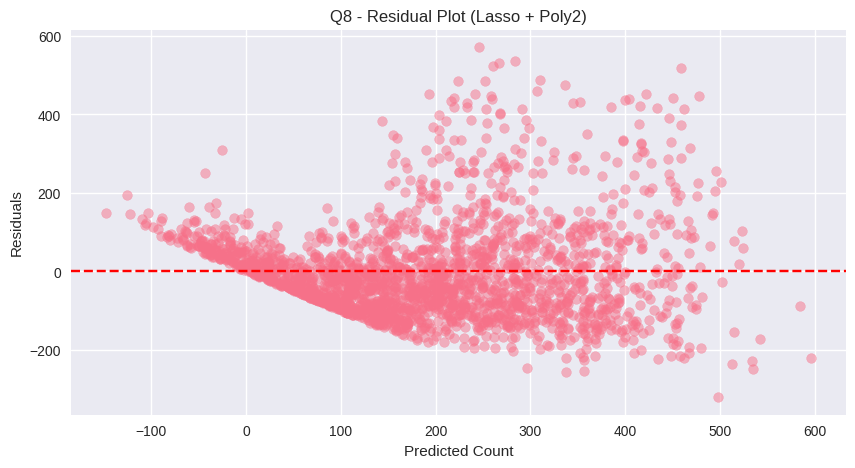

In [61]:
#  Q8: Residual plot for best model (Lasso)
residuals = y_val - pred_lasso
plt.figure(figsize=(10,5))
plt.scatter(pred_lasso, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Count')
plt.ylabel('Residuals')
plt.title('Q8 - Residual Plot (Lasso + Poly2)')
plt.show()

In [63]:
#  Q9: Why the winning model is better
print("Q9 - Why Lasso + Poly2 wins:")
print("- Linear regression assumes straight-line relationships → fails on hour/temp patterns")
print("- Polynomial features capture non-linear effects (e.g., temp², hour×workingday)")
print("- Lasso applies L1 regularization → removes useless features automatically")
print("- Result: much lower RMSLE and better generalization")

Q9 - Why Lasso + Poly2 wins:
- Linear regression assumes straight-line relationships → fails on hour/temp patterns
- Polynomial features capture non-linear effects (e.g., temp², hour×workingday)
- Lasso applies L1 regularization → removes useless features automatically
- Result: much lower RMSLE and better generalization


In [65]:
#  Reflection Questions (0.25 bonus)
print("Q10. Why RMSLE penalizes under-prediction more gently than RMSE?")
print("→ RMSLE uses log(count+1). Log compresses large values, so relative errors matter more than absolute errors. Under-predicting a large count hurts less than RMSE would.")

print("\nQ11. Trade-offs between simplicity and predictive power?")
print("→ Simple models: fast, interpretable, less overfitting")
print("→ Complex models: higher accuracy but risk overfitting, slower, harder to explain")

print("\nQ12. Why plain Linear Regression fails on time-of-day effects?")
print("→ Hour has a U-shape (peaks at 8am & 5-7pm). Linear model can only draw a straight line → cannot capture this non-linear pattern without polynomial/hour features.")

Q10. Why RMSLE penalizes under-prediction more gently than RMSE?
→ RMSLE uses log(count+1). Log compresses large values, so relative errors matter more than absolute errors. Under-predicting a large count hurts less than RMSE would.

Q11. Trade-offs between simplicity and predictive power?
→ Simple models: fast, interpretable, less overfitting
→ Complex models: higher accuracy but risk overfitting, slower, harder to explain

Q12. Why plain Linear Regression fails on time-of-day effects?
→ Hour has a U-shape (peaks at 8am & 5-7pm). Linear model can only draw a straight line → cannot capture this non-linear pattern without polynomial/hour features.


In [69]:
#  FINAL: Train best model on full data & create submission
final_model = lasso_pipe
final_model.fit(X, y)                                     # train on ALL training data
test_preds = final_model.predict(X_test)
test_preds = np.maximum(test_preds, 0).astype(int)        # no negative bikes

# Create submission in exact format
submission = pd.DataFrame({
    'datetime': test['datetime'].dt.strftime('%d-%m-%Y %H:%M'),
    'Count_Predicted': test_preds
})

submission.to_csv('submission.csv', index=False)
print("submission.csv created successfully!")
submission.head(10)

submission.csv created successfully!


,datetime,Count_Predicted
0,05-06-2012 05:00,94
1,19-03-2011 19:00,191
2,02-04-2012 06:00,159
3,13-07-2012 20:00,412
4,09-11-2011 19:00,226
5,10-03-2012 00:00,0
6,19-05-2011 13:00,215
7,01-05-2011 08:00,153
8,07-07-2012 08:00,293
9,07-05-2011 16:00,355
